# MonaLIA Classification Analysis

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8


In [1]:
from __future__ import print_function
import torch

import os
import sys

import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn import tree 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from IPython.display import Image

## Read the classification results from the IPython store of the previous script

In [2]:
%store -r classified_df
print(classified_df.shape)
classified_df.info()

(262, 29)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 29 columns):
target                      262 non-null object
prediction                  262 non-null object
class2                      262 non-null object
class3                      262 non-null object
class4                      262 non-null object
target_prob                 262 non-null float64
pred_prob                   262 non-null float64
prob2                       262 non-null float64
prob3                       262 non-null float64
prob4                       262 non-null float64
imageFile                   262 non-null object
ref                         262 non-null object
width                       262 non-null int64
height                      262 non-null int64
noticeRef                   262 non-null object
noticeDomain                262 non-null object
noticeRepresentedSubject    262 non-null object
noticeTechnique             245 non-null object
noticeDeno        

#### Alternatively Read saved results from the flat file

In [3]:
classified_df = pd.read_csv('themes_262.tsv', sep='\t')
print(classified_df.shape)
classified_df.head()

(262, 30)


,Unnamed: 0,target,prediction,class2,class3,class4,target_prob,pred_prob,prob2,prob3,...,noticeArtForm,noticeFunction,noticeDiscipline,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeTechnique3,noticeDenomination
0,0,genre iconographique,représentation scientifique,genre iconographique,ornementation,représentation non figurative,0.3422,0.4787,0.3422,0.0973,...,dessin,NaN,NaN,NaN,© Jean de Calan,M5044,mine de plomb,papier (beige),NaN,élément d'ensemble
1,1,genre iconographique,genre iconographique,représentation scientifique,ornementation,représentation non figurative,0.5461,0.5461,0.2048,0.1677,...,dessin,NaN,NaN,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon feutre,papier,NaN,NaN
2,2,genre iconographique,genre iconographique,ornementation,représentation non figurative,représentation scientifique,0.9574,0.9574,0.0370,0.0045,...,dessin,NaN,NaN,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,gouache,papier,couleur,NaN
3,3,genre iconographique,genre iconographique,ornementation,représentation scientifique,représentation non figurative,0.5919,0.5919,0.2624,0.0981,...,dessin,NaN,NaN,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon gras,papier,NaN,NaN
4,4,genre iconographique,genre iconographique,représentation scientifique,ornementation,représentation non figurative,0.9955,0.9955,0.0036,0.0006,...,photographie,NaN,NaN,NaN,© musée Condé,M5052,NaN,NaN,NaN,tirage photographique


## Output confusion matrix and statistics
This code can be substituted with three lines of code but the output would be more cryptic

confusion_matrix....
classification_report...
accuracy_score....

In [4]:
conf_matrix = pd.crosstab(index=classified_df.prediction, columns=classified_df.target, margins= True)
conf_matrix

target,genre iconographique,ornementation,représentation non figurative,représentation scientifique,All
prediction,,,,,
genre iconographique,47,2,2,4,55
ornementation,4,49,3,3,59
représentation non figurative,2,6,50,1,59
représentation scientifique,6,1,3,79,89
All,59,58,58,87,262


In [5]:
conf_matrix_pct_target = pd.crosstab(index=classified_df.prediction, columns=classified_df.target)\
                        .div(conf_matrix.loc['All',:], axis=0) \
                        .dropna()\
                        .mul(100)\
                        .round(2)
conf_matrix_pct_target

target,genre iconographique,ornementation,représentation non figurative,représentation scientifique
genre iconographique,79.66,3.39,3.39,6.78
ornementation,6.90,84.48,5.17,5.17
représentation non figurative,3.45,10.34,86.21,1.72
représentation scientifique,6.90,1.15,3.45,90.80


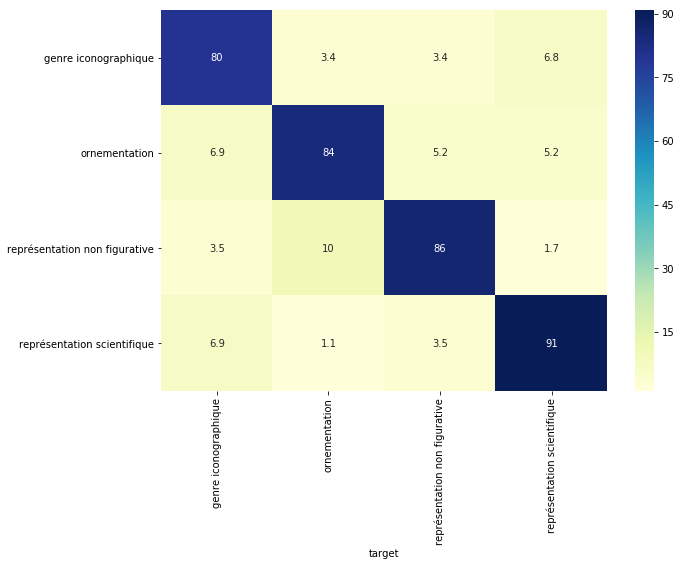

In [6]:
plt.figure(figsize = (10,7))

sns.heatmap(conf_matrix_pct_target, annot=True, cmap="YlGnBu")

<Figure size 720x504 with 0 Axes>

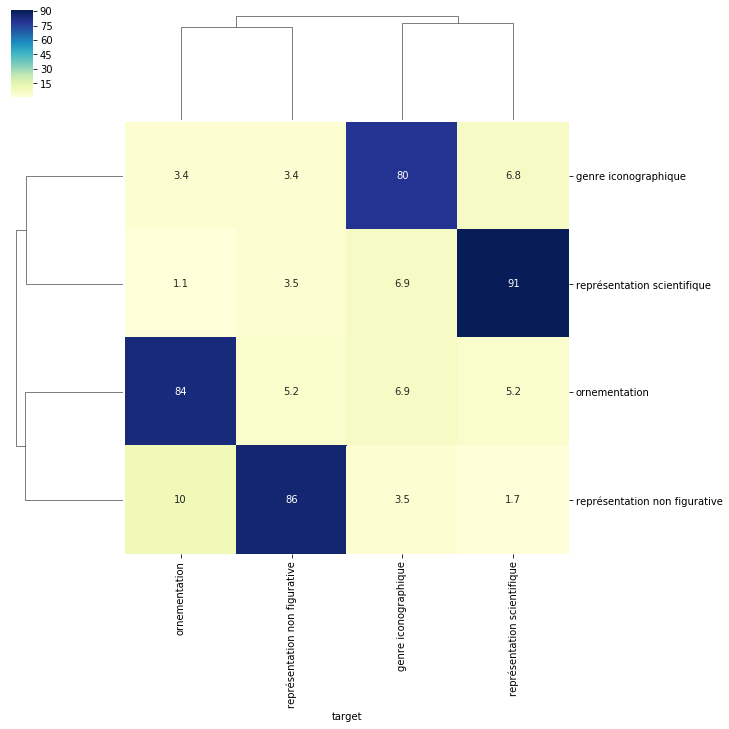

In [7]:
plt.figure(figsize = (10,7))

sns.clustermap(conf_matrix_pct_target, annot=True, cmap="YlGnBu", metric="correlation")

In [8]:
prfs = metrics.precision_recall_fscore_support(y_true= classified_df.target,
                 y_pred= classified_df.prediction)

acc = metrics.accuracy_score(y_true= classified_df.target,
                 y_pred= classified_df.prediction)

output = pd.concat((pd.Series(conf_matrix.index[:-1]) ,
           pd.Series(prfs[3].round(3)),         
           pd.Series(prfs[1].round(3)),
           pd.Series(prfs[0].round(3)),
           pd.Series(prfs[2].round(3)),
           pd.Series(acc.round(3))),
           
           axis=1 )
output.columns = ['class', 'support', 'recall', 'precision', 'f1 score', 'accuracy']
output

,class,support,recall,precision,f1 score,accuracy
0,genre iconographique,59,0.797,0.855,0.825,0.859
1,ornementation,58,0.845,0.831,0.838,NaN
2,représentation non figurative,58,0.862,0.847,0.855,NaN
3,représentation scientifique,87,0.908,0.888,0.898,NaN


In [9]:
classified_df['outcome'] = (classified_df.target == classified_df.prediction).astype(int)
classified_df.outcome.value_counts()

1    225
0     37
Name: outcome, dtype: int64

## Missclassifications

In [10]:
miss_classified_df = classified_df.loc[classified_df.outcome == False]
miss_classified_df.head()

,Unnamed: 0,target,prediction,class2,class3,class4,target_prob,pred_prob,prob2,prob3,...,noticeFunction,noticeDiscipline,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeTechnique3,noticeDenomination,outcome
0,0,genre iconographique,représentation scientifique,genre iconographique,ornementation,représentation non figurative,0.3422,0.4787,0.3422,0.0973,...,NaN,NaN,NaN,© Jean de Calan,M5044,mine de plomb,papier (beige),NaN,élément d'ensemble,0
16,16,genre iconographique,représentation non figurative,ornementation,genre iconographique,représentation scientifique,0.0551,0.7581,0.1627,0.0551,...,NaN,ethnologie,NaN,© Société Tribvn 2009-2010 - utilisation soumi...,M0064,gélatino-bromure d'argent,verre,négatif,plaque de verre photographique,0
17,17,genre iconographique,ornementation,représentation non figurative,genre iconographique,représentation scientifique,0.1510,0.4073,0.3416,0.1510,...,NaN,NaN,NaN,© POUMEYROL,M0098,peinture à l'huile,toile,NaN,tableau,0
32,32,genre iconographique,ornementation,représentation non figurative,représentation scientifique,genre iconographique,0.0357,0.6021,0.2576,0.1044,...,NaN,archéologie,NaN,"© DE SOUSA David, musée Alfred Danicourt",M0815,cuivre,frappé,NaN,monnaie,0
33,33,genre iconographique,ornementation,représentation non figurative,représentation scientifique,genre iconographique,0.0357,0.6021,0.2576,0.1044,...,NaN,numismatique,NaN,"© DE SOUSA David, musée Alfred Danicourt",M0815,cuivre,frappé,NaN,monnaie,0


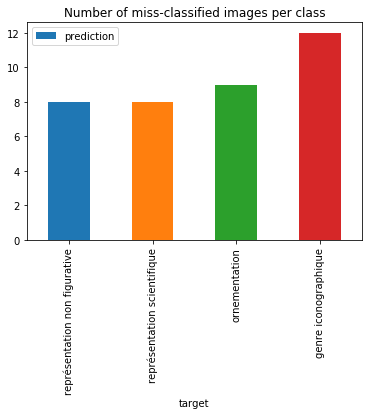

In [11]:
miss_classified_df.groupby(miss_classified_df.target).count() \
                                                     .sort_values(by='prediction') \
                                                     .plot \
                                                     .bar(y='prediction' , 
                                                          title='Number of miss-classified images per class')

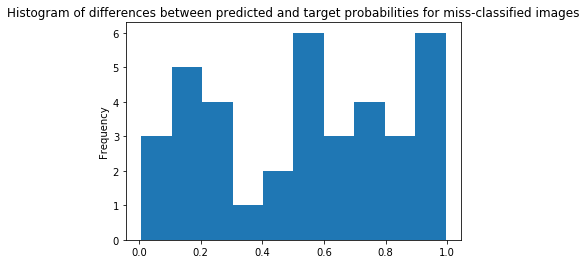

In [12]:
#fig = plt.gcf()
#fig.set_size_inches(18.5, 5.5)

(miss_classified_df.pred_prob-miss_classified_df.target_prob).plot \
                                                             .hist(title = 'Histogram of differences between predicted and target probabilities for miss-classified images')


## Outcome vs. continous variables

In [13]:
classified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 31 columns):
Unnamed: 0                  262 non-null int64
target                      262 non-null object
prediction                  262 non-null object
class2                      262 non-null object
class3                      262 non-null object
class4                      262 non-null object
target_prob                 262 non-null float64
pred_prob                   262 non-null float64
prob2                       262 non-null float64
prob3                       262 non-null float64
prob4                       262 non-null float64
imageFile                   262 non-null object
ref                         262 non-null object
width                       262 non-null int64
height                      262 non-null int64
noticeRef                   262 non-null object
noticeDomain                262 non-null object
noticeRepresentedSubject    262 non-null object
noticeTechnique             2

Text(0.5,0,'1/ar')

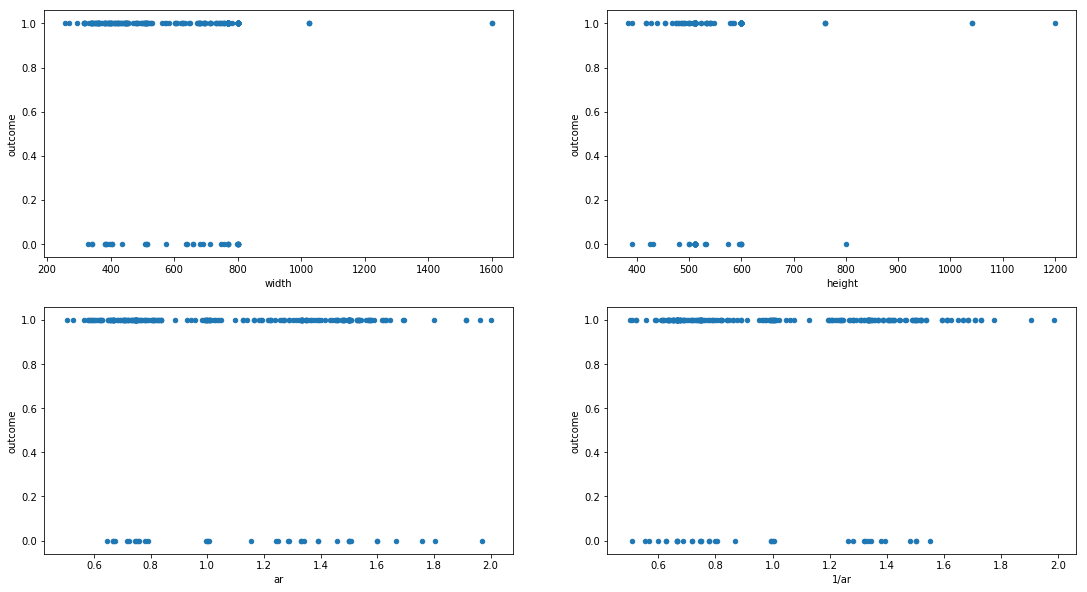

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18.5, 10)


classified_df.plot.scatter(y='outcome' , x='width',  ax=axes[0,0])
classified_df.plot.scatter(y='outcome' , x='height', ax=axes[0,1])

classified_df['ar'] = classified_df.width/classified_df.height
classified_df.plot.scatter(y='outcome' , x='ar', ax=axes[1,0])

classified_df['inv_ar'] = classified_df.height/classified_df.width
ax = classified_df.plot.scatter(y='outcome' , x='inv_ar', ax=axes[1,1] )

ax.set_xlabel("1/ar")

In [15]:
for col in ['width' , 'height', 'ar', 'inv_ar']:

    X = np.where(classified_df[col].dtype == np.int64, 
                 classified_df[col] // 100,
                 classified_df[col] * 10) 
    y=classified_df.outcome.values

    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    
    print('=' * 78)
    print(col + (' / 100' if classified_df[col].dtype == np.int64 else ' * 10'))
    
    print('=' * 78)
    print(result.summary())

    print('exp(coef) = %.4f' % np.exp(result.params[0]))
    print('=' * 78)

Optimization terminated successfully.
         Current function value: 0.442058
         Iterations 6
width / 100
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  262
Model:                          Logit   Df Residuals:                      261
Method:                           MLE   Df Model:                            0
Date:                Wed, 07 Nov 2018   Pseudo R-squ.:                -0.08567
Time:                        15:16:34   Log-Likelihood:                -115.82
converged:                       True   LL-Null:                       -106.68
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3061      0.033      9.250      0.000       0.241       0.371
exp(coef) = 1.358

#### Make up a continious variable that is a difference between predicted and target probabilities for missclassified images (negative) and a difference between target probability and the next class probability for correctly classified images (positive)

In [16]:
classified_df['prob_diff'] = np.where(classified_df.target==classified_df.prediction ,
                                      classified_df.target_prob-classified_df.prob2,
                                      classified_df.target_prob-classified_df.pred_prob)

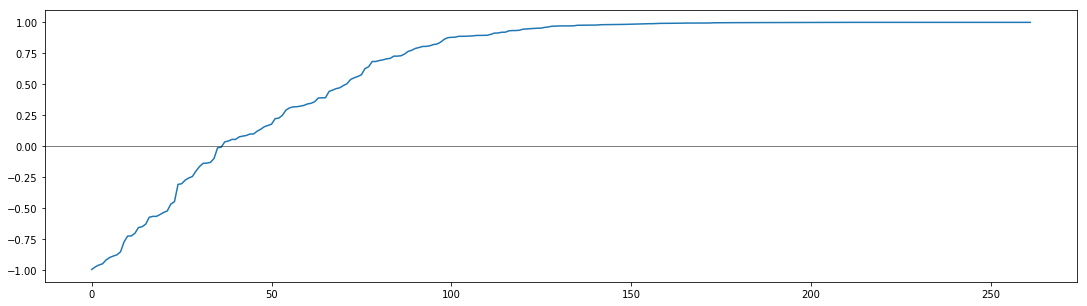

In [17]:
fig, axes = plt.subplots()
fig.set_size_inches(18.5, 5)

classified_df.prob_diff.sort_values() \
                       .plot(use_index=False)

axes.axhline(y=0 , color='k' , linewidth=0.5)

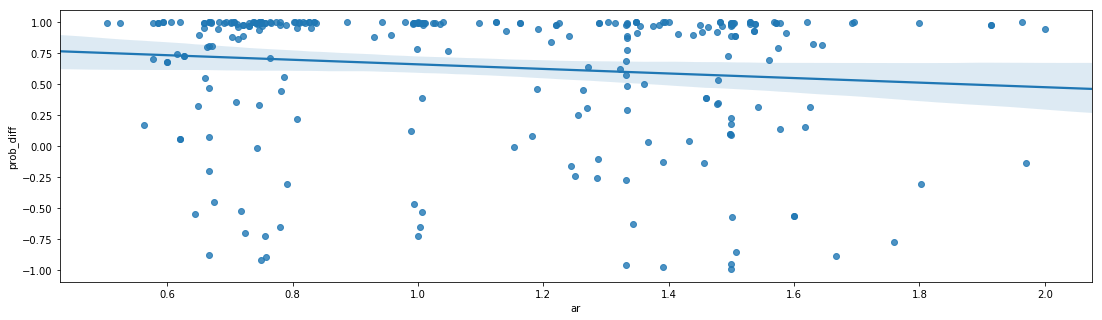

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.012   
Dependent Variable: y                AIC:                431.1138
Date:               2018-11-07 15:16 BIC:                438.2505
No. Observations:   262              Log-Likelihood:     -213.56 
Df Model:           1                F-statistic:        4.089   
Df Residuals:       260              Prob (F-statistic): 0.0442  
R-squared:          0.015            Scale:              0.30119 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const      0.8463     0.1057    8.0075   0.0000    0.6381    1.0544
x1        -0.1847     0.0913   -2.0222   0.0442   -0.3646   -0.0048
-----------------------------------------------------------------
Omnibus:             70.685       Durbin-Watson:          1.533  
Prob(Omnibus):   

In [18]:
fig, axes = plt.subplots()
fig.set_size_inches(18.5, 5)

sns.regplot(x='ar', y='prob_diff', data=classified_df)
plt.show()

X=classified_df.ar.values
y=classified_df.prob_diff.values

X1 = sm.add_constant(X)
lm_model=sm.OLS(y,X1)
result=lm_model.fit()
print(result.summary2())

#p = lm_model.fit().params

#print(p)



In [19]:
classified_df = classified_df.drop(['ar', 'inv_ar'], axis=1)

## Work with Categorical variables

In [20]:
classified_df = classified_df.drop(['noticeArtForm', 'noticeDeno'], axis=1)

In [21]:
classified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 30 columns):
Unnamed: 0                  262 non-null int64
target                      262 non-null object
prediction                  262 non-null object
class2                      262 non-null object
class3                      262 non-null object
class4                      262 non-null object
target_prob                 262 non-null float64
pred_prob                   262 non-null float64
prob2                       262 non-null float64
prob3                       262 non-null float64
prob4                       262 non-null float64
imageFile                   262 non-null object
ref                         262 non-null object
width                       262 non-null int64
height                      262 non-null int64
noticeRef                   262 non-null object
noticeDomain                262 non-null object
noticeRepresentedSubject    262 non-null object
noticeTechnique             2

#### Eliminate variables with missing data less than a threshold (TBD)

In [22]:
kb_col = pd.Series(classified_df.columns)
kb_col = kb_col[kb_col.str.startswith('notice')]
kb_col = kb_col[4:]

kb_col_to_keep = []
miss_val_threshold = 0.33
for col in kb_col:
    print(col)
    print('Number of categories: %d' % classified_df[col].unique().size)

    missing_count = classified_df[col].loc[(classified_df[col] == '')].count()
    missing_count += classified_df[classified_df[col].isnull()].shape[0]
    
    missing_values_ratio = missing_count / classified_df.shape[0]
    
    if (missing_values_ratio < miss_val_threshold):
        kb_col_to_keep.append(col)
    print('Missing values: %d%%' % (missing_values_ratio * 100))
    
    print()

kb_col_to_keep   


noticeFunction
Number of categories: 4
Missing values: 96%

noticeDiscipline
Number of categories: 8
Missing values: 62%

noticeRepresentationType
Number of categories: 4
Missing values: 22%

noticePhotocredit
Number of categories: 92
Missing values: 0%

noticeMuseum
Number of categories: 65
Missing values: 18%

noticeTechnique1
Number of categories: 78
Missing values: 6%

noticeTechnique2
Number of categories: 76
Missing values: 26%

noticeTechnique3
Number of categories: 45
Missing values: 61%

noticeDenomination
Number of categories: 52
Missing values: 24%



['noticeRepresentationType',
 'noticePhotocredit',
 'noticeMuseum',
 'noticeTechnique1',
 'noticeTechnique2',
 'noticeDenomination']

In [23]:
kb_col_to_keep.append('outcome')

In [24]:
categorical_data = classified_df[kb_col_to_keep].copy()
categorical_data.head()

,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeDenomination,outcome
0,NaN,© Jean de Calan,M5044,mine de plomb,papier (beige),élément d'ensemble,0
1,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon feutre,papier,NaN,1
2,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,gouache,papier,NaN,1
3,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon gras,papier,NaN,1
4,NaN,© musée Condé,M5052,NaN,NaN,tirage photographique,1


In [25]:
categorical_data[categorical_data.isnull().any(axis=1)].head()

,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeDenomination,outcome
0,NaN,© Jean de Calan,M5044,mine de plomb,papier (beige),élément d'ensemble,0
1,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon feutre,papier,NaN,1
2,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,gouache,papier,NaN,1
3,NaN,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon gras,papier,NaN,1
4,NaN,© musée Condé,M5052,NaN,NaN,tirage photographique,1


#### Fill the missing values

In [26]:
categorical_data.replace("" , "z_missing", inplace=True)
categorical_data.fillna("z_missing", inplace=True)
categorical_data.head()

,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeDenomination,outcome
0,z_missing,© Jean de Calan,M5044,mine de plomb,papier (beige),élément d'ensemble,0
1,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon feutre,papier,z_missing,1
2,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,gouache,papier,z_missing,1
3,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon gras,papier,z_missing,1
4,z_missing,© musée Condé,M5052,z_missing,z_missing,tirage photographique,1


#### Clean the technique columns a bit

In [27]:
categorical_data.noticeTechnique1 = categorical_data.noticeTechnique1.apply(lambda x: x.split('(')[0].strip()) 
#categorical_data.noticeTechnique2 = categorical_data.noticeTechnique2.apply(lambda x: x.split('(')[0].strip()) 
categorical_data.head()

,noticeRepresentationType,noticePhotocredit,noticeMuseum,noticeTechnique1,noticeTechnique2,noticeDenomination,outcome
0,z_missing,© Jean de Calan,M5044,mine de plomb,papier (beige),élément d'ensemble,0
1,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon feutre,papier,z_missing,1
2,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,gouache,papier,z_missing,1
3,z_missing,© Claudine Pigot - utilisation soumise à autor...,M1096,crayon gras,papier,z_missing,1
4,z_missing,© musée Condé,M5052,z_missing,z_missing,tirage photographique,1


#### Reduce Number of categories

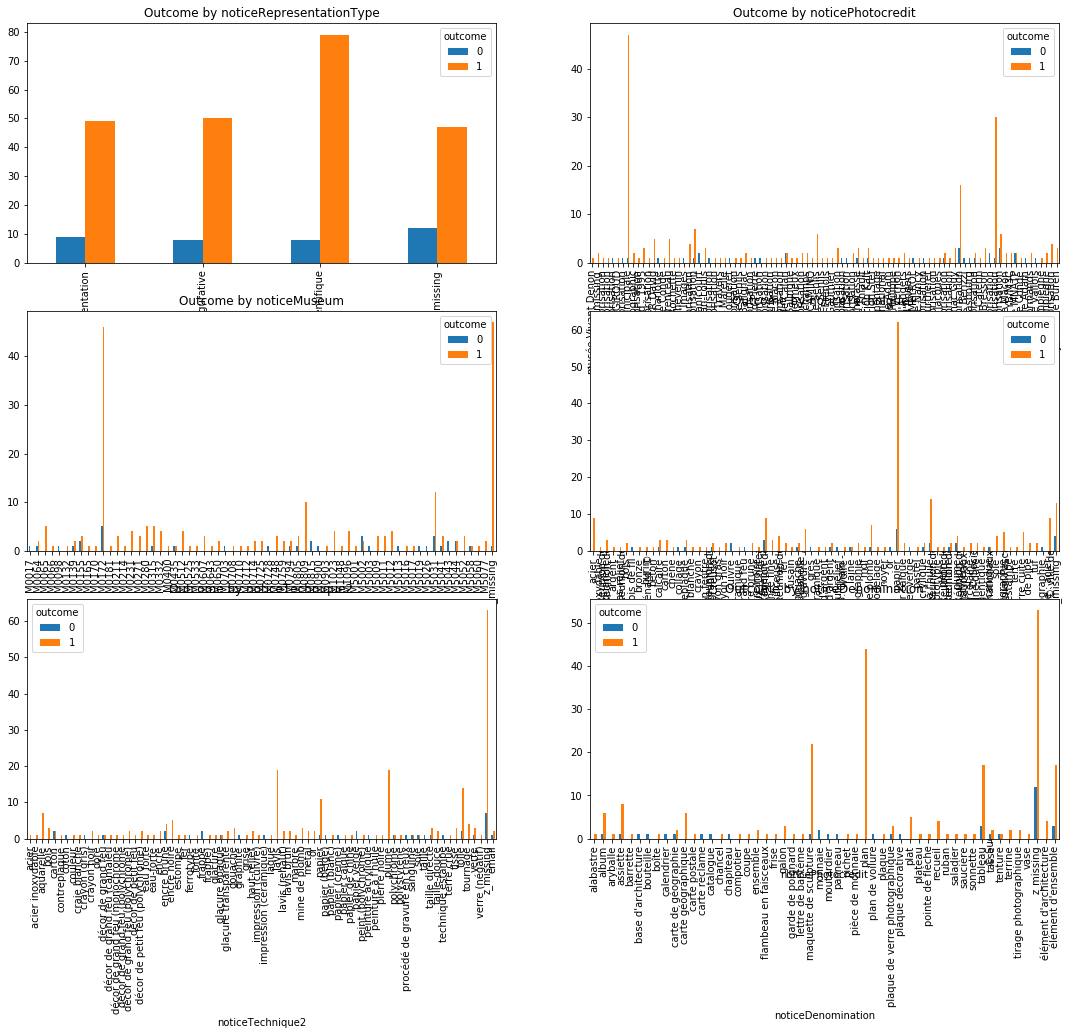

In [28]:
n_rows = (categorical_data.shape[1]-1)//2 + (categorical_data.shape[1] - 1)%2

fig, axes = plt.subplots(nrows=n_rows, ncols=2)
fig.set_size_inches(18.5, 5 * n_rows)

for i , col in enumerate(kb_col_to_keep[:-1]):

    subplot1 = pd.crosstab(categorical_data[col], categorical_data.outcome).plot(kind='bar', ax=axes[i//2 , int(i%2)] )
    subplot1.set_title('Outcome by %s' % col)
    subplot1.set_xlabel(col)


In [29]:
categorical_data_reduced = categorical_data.copy()

cat_size_threshlod_dict = {'noticeRepresentationType': 40,
                           'noticePhotocredit': 15,
                           'noticeMuseum': 20,
                           'noticeTechnique1' : 30,
                            'noticeDenomination' : 25, }
cat_size_threshlod_dict

{'noticeRepresentationType': 40,
 'noticePhotocredit': 15,
 'noticeMuseum': 20,
 'noticeTechnique1': 30,
 'noticeDenomination': 25}

In [ ]:
n_rows = categorical_data.shape[1]-1

fig, axes = plt.subplots(nrows=n_rows, ncols=2)
fig.set_size_inches(18.5, 5 * n_rows)

for i , col in enumerate(kb_col_to_keep[:-1]):

    pd.crosstab(categorical_data[col], categorical_data.outcome).plot(kind='bar', ax=axes[i , 0] )\
                                                            .set_title('Outcome by %s (before)' % col) 

    cat = categorical_data.groupby(by=col).size().sort_values(ascending=False)

    categorical_data_reduced[col] = categorical_data[col].replace(cat[cat <= cat_size_threshlod_dict[col]].index.values , \
                                                                    "z_other")

    pd.crosstab(categorical_data_reduced[col], categorical_data_reduced.outcome).plot(kind='bar', ax=axes[i, 1] )\
                                                                                .set_title('Outcome by %s (after)' % col) 
    

In [ ]:
#for i , col in enumerate(categorical_data_reduced.columns[:-1]):
#    categorical_data_reduced[col] = pd.Categorical(categorical_data_reduced[col])
   
#categorical_data_reduced.info()

In [ ]:
categorical_data_reduced.head()

In [ ]:
pd.get_dummies(categorical_data_reduced, columns=['noticeTechnique1'], prefix = ['noticeTechnique1'.replace('notice', '' )]).iloc[:, offset:]

In [ ]:
offset = categorical_data_reduced.shape[1] - 1

for i , col in enumerate(categorical_data_reduced.columns[:-1]):
    
    X= pd.get_dummies(categorical_data_reduced, columns=[col], prefix = [col.replace('notice', '' )]).iloc[:, offset:]
    y=categorical_data_reduced.outcome
    
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print('=' * 78)
    print(col)
    
    print('=' * 78)
    print(result.summary())
    
    print('exp(coef):')
    print(np.exp(result.params))
    print('=' * 78)


## Feature selection

#### Create Dummy Indicator variables

In [ ]:
categorical_data_copy = categorical_data_reduced.copy()

for i , col in enumerate(categorical_data_copy.columns[:-1]):
    categorical_data_copy = pd.get_dummies(categorical_data_copy, columns=[col], prefix = [col.replace('notice', '' )])


categorical_data_copy.head()

#### Using scikit.learn Recursive Feature Elimination
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [ ]:
col_to_analize = pd.Series(categorical_data_copy.columns)[1:]

logreg = LogisticRegression()

rfe = RFE(logreg, 6)
rfe = rfe.fit(categorical_data_copy[col_to_analize], categorical_data_copy['outcome'] )

print(rfe.n_features_ )
print(rfe.support_)
print(rfe.ranking_)

print(col_to_analize[rfe.support_])

#### Build a decision tree for the selected features

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)

X = categorical_data_copy[col_to_analize]
y = categorical_data_copy.outcome

clf.fit(X, y)

#### Decision Tree Visualization

https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/

In [ ]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=categorical_data_copy.columns[1:],
                                filled = True,
                                rounded= True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#### Display Tree with Proprtions

In [ ]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=categorical_data_copy.columns[1:],
                                filled = True,
                                proportion = True,
                                rounded = True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())







## Scrapbook

#### R-style logistic regression

In [ ]:
import statsmodels.api as sm

model = sm.formula.glm("outcome ~ C(noticeTechnique2)",
                       family=sm.families.Binomial(), data=classified_df).fit()
print(model.summary())

#### Using Chi-square test to select variables one by one

In [ ]:
import scipy.stats as stats
p_values = []
for i, col in enumerate(categorical_data_copy.columns[1:]):
    _, p , _, _ = stats.chi2_contingency(observed= pd.crosstab(categorical_data_copy[col], categorical_data_copy.outcome))
    #_, p  = stats.fisher_exact(pd.crosstab(classified_df_copy[col], classified_df_copy.outcome))
    #print(col, round(p ,3))
    p_values.append(round(p ,6))

p_s = pd.Series(p_values, index=categorical_data_copy.columns[1:])
p_s[p_s.values < 0.2].sort_values()
#plt.plot(p_values)



In [ ]:
print(metrics.classification_report(y_true= classified_df.target,
                 y_pred= classified_df.prediction,
                 target_names= test_set.classes))

In [ ]:
miss_classified = (classified [(classified[:,0] - classified[:,1] != 0).nonzero(),:]).squeeze() 

In [ ]:
def to_class_label(idx):
    return test_set.classes[idx]

In [ ]:
# JUst a reminder on what is what
what = 'chat'

tp = conf_matrix.loc[what,what]
print ('tp=%d' % tp)

fp = conf_matrix.loc[what,'All'] - tp
print ('fp=%d' % fp)

fn = conf_matrix.loc['All', what] - tp
print ('fp=%d' % fn)

recall = tp /(tp+fn)
print ('recall=%f' % recall)

prec = tp /(tp+fp)
print ('prec=%f' % prec)

fscore = 2 * prec * recall /(prec + recall)
print ('fscore=%f' % fscore)


In [ ]:
print(metrics.confusion_matrix(y_true= classified_df.target,
                 y_pred= classified_df.prediction))


In [ ]:
r = metrics.recall_score(y_true= classified_df.target,
                 y_pred= classified_df.prediction,
                 average= None)

p = metrics.precision_score(y_true= classified_df.target,
                 y_pred= classified_df.prediction,
                 average= None)

f = metrics.f1_score(y_true= classified_df.target,
                 y_pred= classified_df.prediction,
                 average= None)

a = metrics.accuracy_score(y_true= classified_df.target,
                 y_pred= classified_df.prediction)

output = pd.concat((pd.Series(test_set.classes) ,
                    
           pd.Series(r.round(3)),
           pd.Series(p.round(3)),
           pd.Series(f.round(3)),
           pd.Series(a.round(3))),
           
           axis=1 )
output.columns = ['class', 'recall', 'precision', 'f1 score', 'accuracy']
output

In [ ]:
prfs = metrics.precision_recall_fscore_support(y_true= classified_df.target,
                 y_pred= classified_df.prediction)

output = pd.concat((pd.Series(test_set.classes) ,
           pd.Series(prfs[3].round(3)),         
           pd.Series(prfs[1].round(3)),
           pd.Series(prfs[0].round(3)),
           pd.Series(prfs[2].round(3)),
           pd.Series(a.round(3))),
           
           axis=1 )
output.columns = ['class', 'support', 'recall', 'precision', 'f1 score', 'accuracy']
output

In [ ]:
numberList = [1, 2, 3]
strList = ['one', 'two', 'three']

# No iterables are passed
result = zip()

#Converting itertor to list
resultList = list(result)
print(resultList)

# Two iterables are passed
result = zip(numberList, strList)

# Converting itertor to set
resultSet = set(result)
print(resultSet)

In [ ]:
np.random.seed(10)

# Sample data randomly at fixed probabilities
voter_race = np.random.choice(a= ["asian","black","hispanic","other","white"],
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Sample data randomly at fixed probabilities
voter_party = np.random.choice(a= ["democrat","independent","republican"],
                              p = [0.4, 0.2, 0.4],
                              size=1000)

voters = pd.DataFrame({"race":voter_race, 
                       "party":voter_party})
voters

voter_tab = pd.crosstab(voters.race, voters.party, margins = True)

voter_tab.columns = ["democrat","independent","republican","row_totals"]

voter_tab.index = ["asian","black","hispanic","other","white","col_totals"]

observed = voter_tab.iloc[0:5,0:3]   # Get table without totals for later use
voter_tab

In [ ]:
60*186

In [ ]:
expected =  np.outer(voter_tab["row_totals"][0:5],
                     voter_tab.loc["col_totals"][0:3]) / 1000

expected = pd.DataFrame(expected)

expected.columns = ["democrat","independent","republican"]
expected.index = ["asian","black","hispanic","other","white"]

expected

In [ ]:
pd.crosstab(classified_df_copy.artForm_peinture, classified_df_copy.outcome,  margins= True)

In [ ]:

_, p , _, _ = stats.fisher_exact(observed= pd.crosstab(classified_df_copy.artForm_peinture, classified_df_copy.outcome))
p

In [ ]:
stats.fisher_exact??

In [ ]:
classified_df.to_csv('image_classification_4000_without_birds.tsv', sep="\t")

In [ ]:
classified_df = pd.read_csv('image_classification_4000.tsv', sep='\t')
print(classified_df.shape)
classified_df.head()

In [ ]:
#labels = classified_df.noticeArtForm.astype('category').cat.categories.tolist()
#replace_map_comp = {'noticeArtForm' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

#print(replace_map_comp['noticeArtForm'])

classified_df_copy = classified_df.copy()
#classified_df_copy.noticeArtForm.replace(replace_map_comp['noticeArtForm'], inplace=True)
#classified_df_copy.noticeArtForm = classified_df_copy.noticeArtForm.astype('category')

#classified_df_copy.noticeArtForm = classified_df_copy.noticeArtForm.cat.codes

classified_df_copy = pd.get_dummies(classified_df_copy, columns=['noticeArtForm'], prefix = ['artForm'])


classified_df_copy.head()